# A tutorial on image classification using fastaiv2
> Fastai v2 is a deep learning library which makes training deep learning models simple. Here in this tutorial we will understand how to train a image classifier effectively. We will also deep dive into midlevel apis and see how they will help us is in customizing different aspects of deep learning modelling. 

- toc: true 
- badges: true
- comments: true
- hide: false
- search_exclude: false
- categories: [fastai, python, deep-learning]
- image: images/favicon.ico

## Introduction
classifying objects is one of the primary tasks of Deep learning in computer vision. If this happens at image level it is called image classification and at pixel level it is called segmentation. Image (object) classification is the core for any analytics work you do on images. In this blogpost, lets see how image classification is done effectively using fastaiv2. 

## Dataset and DataBlock
The fundamental thing which we need for any task is dataset. In fastaiv2, dataset is represented in many formats.

In [1]:
from fastai2.vision.all import *

> Note: Fastaiv2 has several [datasets](https://course.fast.ai/datasets) apis which we can download simply using the below command

In [2]:
path = untar_data(URLs.PETS)
files = get_image_files(path) # get all the image files

There are several ways in which we can create a dataloader using Fastaiv2 and using DataBlock we can define in the following way.
- create a func (label_func) which extracts class name from the dataset. dsets.vocab shows the classes of the dataset
- get_image_files extracts images from path provided at dblocks.datasets. We can also use **FileGetter(extensions=".jpg")** as an input to get_items if u want to specify the params.
- There are several [splitters](https://github.com/fastai/fastai2/blob/master/nbs/05_data.transforms.ipynb) available in the fastaiv2 including 
    - RandomSplitter: takes fraction of validation data as input
    - TrainTestSplitter: A wrapper to sklearn train_test_split function 
    - IndexSplitter: takes the index of valid_idx as input 
    - GrandparentSplitter: used when your train and val datasets are present in different folders 
    - FuncSplitter: When you write your own function to divide the dataset into train and validation
    - FileSplitter: image names present in a file.txt as valid
    - RandomSubsetSplitter: give fractions to both train and val
    - ColSplitter: split the dataset based on a column
- blocks: Kind of outputs we need, here since we are using images and need category as output we are using ImageBlock and CategoyBlock.
    - Use ImageBlock(cls=PILImageBW) when u need a Black & white image as input to network
    - Use MultiCategory block when u are training a multi-class classification.
    - TODO

In [3]:
def label_func(fname):
    return "cat" if fname.name[0].isupper() else "dog"

In [4]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = RandomSplitter(), 
                   item_tfms = Resize(224))
dsets = dblock.datasets(path)

> Tip: dsets is similar to dataset in Pytorch. We can write our own dsets if fastai DataBlock doesn't work for us, please make sure we implement show method to visualize an input.

> Important: if you have multiple input blocks, we need to include **n_inp** input and accordingly adjust our blocks

dsets is a dataset. if we need a dataloader, we need to call dataloader method. dataloader method is very similar to dataloader in Pytorch. It has arguments like batch_size(bs), shuffle, pin_memory, drop_last. 

> Tip: Fastai uses delegates for auto-completion and to see what arguments are present, do **shift+tab** to check all the arguments on a function.

> Important: Fastai dataloader comes with a show batch functionality, which will help you visualize a batch of images.

In [5]:
dls = dblock.dataloaders(path/"images", bs=32)

> Warning: show_batch doesn't work if all the images are not of the same size. we need to define item_tfms to resize all the images to the same size.

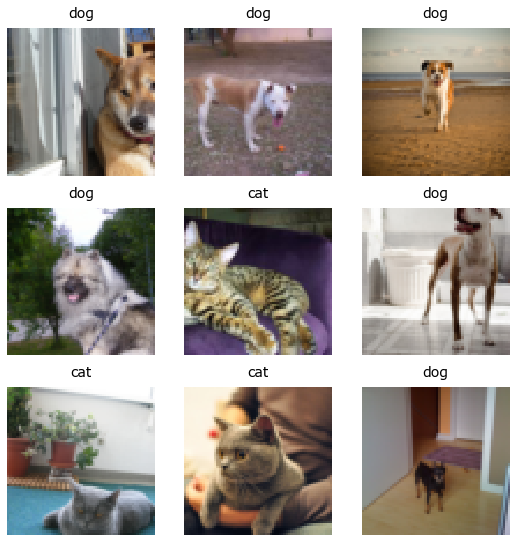

In [6]:
dls.show_batch()

> Important: In vision we also have ImageDataLoaders where we can initialize as a dataloader in a single line depending on the type of input

## ImageDataLoaders 
- There are several different [image data loaders](http://dev.fast.ai/vision.data) depending on the type of input data. Here since our data is coming from paths

In [7]:
fnames = get_image_files(path/"images")
dls = ImageDataLoaders.from_path_func(path/"images", 
                                      fnames, 
                                      label_func, 
                                      valid_pct=0.2,
                                      item_tfms=Resize(224))

## Transformations and Agumentations. 

Deep learning architecutures contain large number of parameters (in millions) and it is very hard to achieve generalization with limited datasets. even the large scale imagenet dataset also contain 1.3 million images. Thanks to the image agumentations, we can randomly flip, rotate, resize, pad, crop and do many other image [agumentations](https://github.com/albumentations-team/albumentations) and create an artificially large dataset which will help us in training deep learning models.

In fastaiv2, we have two different types transformations 
- item transforms 
- batch transforms 

Traditionally everything is performed as item transform but fastai cleverly divided transformations/agumentations into two different types. one which is applied on images and one which is applied on tensors. one which are applied on images are called item transforms and these are performed on cpu irrespective of GPU availability. batch transforms are applied on tensors and can be done GPU like normalization and standardization. we can have a look at different transforms implementation [here](http://dev.fast.ai/vision.augment)

In [8]:
dls = ImageDataLoaders.from_path_func(path/"images", 
                                      fnames, 
                                      label_func, 
                                      valid_pct=0.2, 
                                      item_tfms=[FlipItem(0.5), Resize(224, method="pad")], 
                                      batch_tfms=[Normalize.from_stats(*imagenet_stats)])

> Tip: use dls.one_batch() gives one batch of imgtensor and labels. use this to test/check loss functions, network and dataloader ouputs. 

TODO:
- writing your own item_tfms or batch_tfms

## Networks
We will specifically talk about fastaiv2 computer vision architectures. fastaiv2.vision.learner has create_head, create_body and create_cnn_model. specifically a network is divided into two parts: body and head. later we will see in learner how this will be useful. 


In [9]:
encoder = create_body(resnet18, n_in=3, pretrained=False)
head = create_head(nf=512, n_out=2, concat_pool=False)
model = nn.Sequential(encoder, head)

> Tip: We can directly call create_cnn_learner and define the network in one single line. The nf feature is directly computed in this case. 

In [10]:
model = create_cnn_model(resnet18, n_out=2, pretrained=True, n_in=3, custom_head=None)

> Important: resnet18 is a function which takes pretrained as an argument, if you are defining your own architecture, make sure that it takes this as an argument. 

In [11]:
from segmentation_models_pytorch.encoders import get_encoder
def SimpleArch(encoder: str= "resnet18"):
    def model(pretrained: Union[str]=None):
        return get_encoder(encoder, in_channels=3, depth=5, weights=pretrained)
    return model

> Note: we can define custom heads to the create_cnn_model. 

In [12]:
@delegates(create_head, but="nf, n_out")
class FastaiDecoder(Module):
    def __init__(self, name, nf, n_out, **kwargs):
        store_attr(self, "name, nf, n_out")
        setattr(self, f"{self.name}_decoder", create_head(nf, n_out, **kwargs))
        
    def forward(self, x):
        x = getattr(self, f"{self.name}_decoder")(x)
        return x

In [13]:
encoder = create_body(SimpleArch("resnet18"), n_in=3, pretrained=None)
head = FastaiDecoder("decoder", 1024, 2)
model = nn.Sequential(encoder, head)

> Tip: FastaiDecoder is inherited from fastaiv2 Module and not torch nn module. when using fastaiv2 Module we need not use super for inheritance. 

> Tip: If we want to train a cnn arch and head, we can directly define them inside cnn_learner and no need to use create_head and create_body functions. Use create_head and create_body when we are using Learner API.

As defined in fastai docs, a learner is a Trainer for model using data to minimize `loss_func` with optimizer `opt_func`. We can use `cnn_learner` or `Learner`, A cnn_learner is a wrapper on top of learner for training vision models much more efficiently as described above. We will be using `Learner` here. 

## Learner 

Learner takes various params. Lets look at each and everything individually
- dls: dataloader 
- model: neural network model 
- loss_func: loss function as input, for example CrossEntropyLossFlat() defined in fastai2
- opt_func: optimizer function, Example: Adam 

### Splitter and lr

How do we set different learning rates to different layer aka discriminative learning? To solve this Learner has a parameter called `splitter` which takes a function (Defined as Groups below). This function takes model as input and outputs a list of lists which contain model parameters. The `lr` tuple length is equivalent to `Groups` output length. 

Below is a groups function defined, it takes model as input and gives encoder params and decoder params in a list of 2 values.  

In [14]:
def Groups(model):
    return [list(model[0].parameters()), list(model[1].parameters())]

### Callbacks 
fastai's training loop is highly extensible, with a rich callback system. There are several [callbacks](https://docs.fast.ai/callbacks.html#callbacks) defined and we can define our own using [callback](https://docs.fast.ai/callback.html#callback). Some of them include, 

### schedular
schedular is passed aS A callback in the fastai framework. There are already defined learner method like `fit_one_cycle`, `fit_sgdr`, `fit_flat_cos`. If we want to define our own schedular, we can define in the following way. The schedular we defined below using `combine_scheds` has two params
- pcts: [0.1, 0.9] list meaning, first 10% of the time use SchedLin and Next 90% of the training time use SchedCos
- scheds: list of schedulars to [use](https://github.com/fastai/fastai2/blob/master/fastai2/callback/schedule.py)

In [15]:
lr = 0.1
sched = {"lr": combine_scheds([0.1, 0.9], [SchedLin(0, lr), SchedCos(lr, 0.01)])}

In [16]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), opt_func=Adam, splitter=Groups, train_bn=False, lr=(0.001, 0.1))

> Note: lr defined when initalizing `Learner` module is overwritten by ParamScheduler.

In [17]:
learn.fit(1, cbs=ParamScheduler(sched))

### train_bn, unfreeze,  freeze and summary
- `unfreeze` will set all params (expect batch norm) requires grad to `True`. 
- `.freeze` will set (expect batch norm) requires grad to `False` upto last param group. internally it calls freeze_to(-1).
- freeze_to can be used to customize till where u want to freeze. 
- If train_bn, batchnorm layer learnable params are trained even for frozen layer groups. set it to `False`

In [18]:
learn.freeze()
learn.summary()

Sequential (Input shape: ['64 x 3 x 64 x 64'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 32 x 32    9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 32 x 32    128        False     
________________________________________________________________
ReLU                 64 x 64 x 32 x 32    0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 16 x 16    0          False     
________________________________________________________________
Conv2d               64 x 64 x 16 x 16    36,864     False     
________________________________________________________________
BatchNorm2d          64 x 64 x 16 x 16    128        False     
________________________________________________________________
ReLU                 64 x 64 x 16 x 16    0          False     
___________________________________________________

### Using SGDR to training 

In [19]:
learn.fit_sgdr(n_cycles=2, cycle_len=1, lr_max=0.1, cycle_mult=2)

In [20]:
plt.plot(learn.recorder.lrs); plt.show()

### Training using mix precision

In [23]:
learn.to_fp16()
learn.fit_sgdr(n_cycles=2, cycle_len=1, lr_max=0.1, cycle_mult=2)

### Predict, save and show_results
Once the model is trained, we want to check performance on test data or deploy (save) the model to validate on new data. Also we need to do an error analysis to understand where the model is making mistakes. The learner has all these methods

In [26]:
learn.predict("/home/fractaluser/.fastai/data/oxford-iiit-pet/images/Abyssinian_10.jpg")

('dog', tensor(1), tensor([9.4309e-17, 1.0000e+00]))

In [27]:
learn.save("model.pkl", with_opt=False)

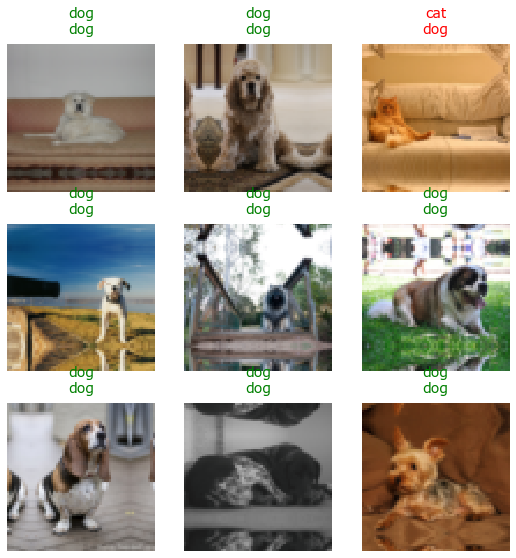

In [24]:
learn.show_results()

# work in progress
- training on a TPU

## Resources
- https://www.kaggle.com/jhoward/fastai-v2-pipeline-tutorial
- https://docs.fast.ai/basic_train.html#Discriminative-layer-training

<script src="https://utteranc.es/client.js"
        repo="carbon2silicon"
        issue-term="pathname"
        theme="github-light"
        crossorigin="anonymous"
        async>
</script>